## Strategy based on EPS surprise 

This signal plays the sign of the difference between actual eps and concensus estimate, it's then mangified by the value of the actual EPS itself

Signal is cross sectionnaly ranked and time series ranked for each stock

Stocks with positive (negative) eps surprise compared to their last years are long (short)

In [2]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [4]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]


In [5]:
earnings.xs('A',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/a/earnings

#more generally we remark almost of all the time correct report date, but we're  still data source dependent

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2022-05-24,2022-05-24,2022-04-30,AfterMarket,USD,1.13,1.12,0.01,0.8929
2022-08-16,2022-08-16,2022-07-31,AfterMarket,USD,1.34,1.20,0.14,11.6667
2022-11-21,2022-11-21,2022-10-31,AfterMarket,USD,1.53,1.39,0.14,10.0719
2023-02-28,2023-02-28,2023-01-31,AfterMarket,USD,1.37,1.30,0.07,5.3846


In [6]:
earnings.xs('UNH',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/unh/earnings
#more generally we remark almost of all the time correct report date, but we're  still data source dependent

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2022-04-14,2022-04-14,2022-03-31,BeforeMarket,USD,5.49,5.38,0.11,2.0446
2022-07-15,2022-07-15,2022-06-30,BeforeMarket,USD,5.57,5.20,0.37,7.1154
2022-10-14,2022-10-14,2022-09-30,BeforeMarket,USD,5.79,5.42,0.37,6.8266
2023-01-13,2023-01-13,2022-12-31,None,USD,5.34,5.17,0.17,3.2882


In [7]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_suprise  = (eps_actual * np.sign((eps_actual - eps_estimate))).reindex_like(P).ffill()[P]


C:\Users\marti\AppData\Local\Temp\ipykernel_16784\617332682.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(126,min_periods=20).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_16784\617332682.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe                2.2
Daily turnover (%)    9.4
biais (bp)            2.1
dtype: float64

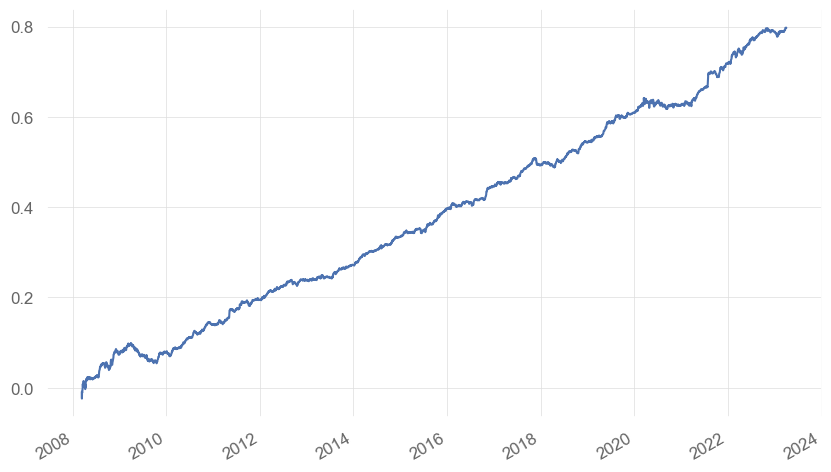

In [11]:
signal = eps_suprise[P]
signal = signal[P].rolling(126,min_periods=20).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Daily turnover (%)':turnover *100,'biais (bp)':PNL.mean()*1e4}).round(1)

<Axes: >

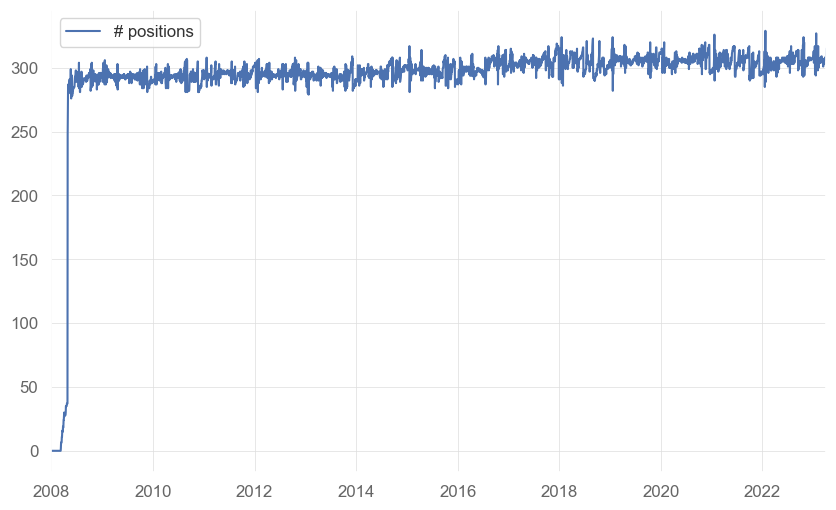

In [12]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

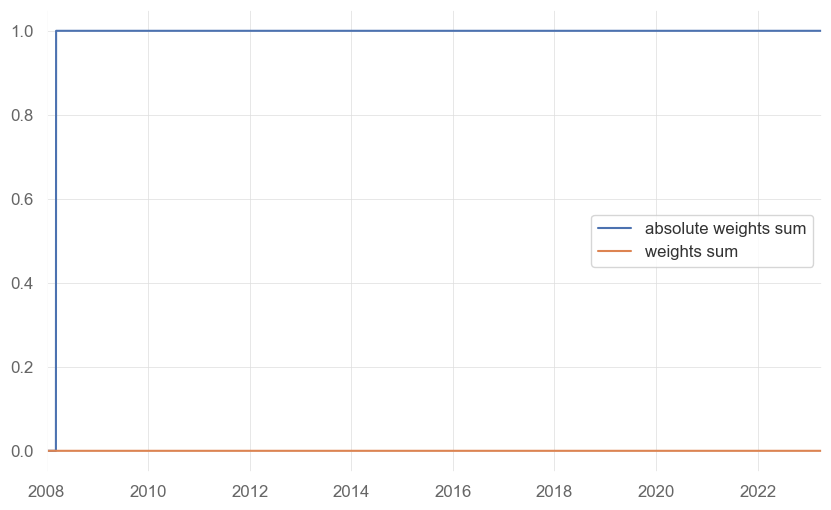

In [13]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)